In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [194]:
ids = Test_data['building_id']

Train_data = Train_data.drop(['building_id'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

In [195]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def na_check2(df_data):
    #missing data
    total = df_data.isnull().sum().sort_values(ascending=False)
    percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data.head(4))
    
def area_type(row):
    if row >= 0:
        return 1
    else:
        return 0

In [196]:
na_check(Train_data)
na_check(Test_data)

,Missing Ratio
parking_area,94.828333
parking_price,76.775000
txn_floor,26.503333
village_income_median,1.903333


,Missing Ratio
parking_area,95.00
parking_price,77.10
txn_floor,26.39
village_income_median,1.84


In [197]:
Train_data.sort_values(by = 'parking_price', ascending = False)[:4]
Train_data = Train_data.drop(55472)
Train_data = Train_data.drop(8795)
Train_data = Train_data.drop(37480)
Train_data = Train_data.drop(51731)

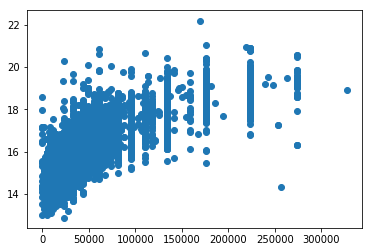

In [198]:
train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["parking_price"], train_Y)

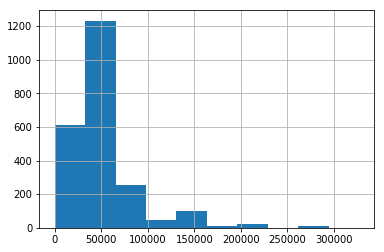

In [199]:
Test_data["parking_price"].hist()

In [200]:
Train_data.sort_values(by = 'land_area', ascending = False)[:10]
Train_data = Train_data.drop(10670)
Train_data = Train_data.drop(41331)
Train_data = Train_data.drop(39191)
Train_data = Train_data.drop(53966)
Train_data = Train_data.drop(7814)
Train_data = Train_data.drop(13332)
Train_data = Train_data.drop(9785)
Train_data = Train_data.drop(14007)
Train_data = Train_data.drop(50076)
Train_data = Train_data.drop(2086)

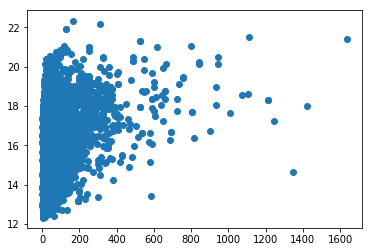

In [201]:
train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["land_area"], train_Y)

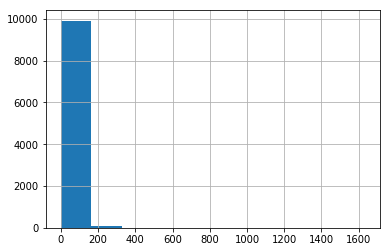

In [202]:
Test_data["land_area"] = Test_data["land_area"].clip(0, Train_data["land_area"].max())

Test_data["land_area"].clip(0, Train_data["land_area"].max()).hist()

In [203]:
Train_data.sort_values(by = 'building_area', ascending = False)[:20]
Train_data = Train_data.drop(9491)
Train_data = Train_data.drop(46934)

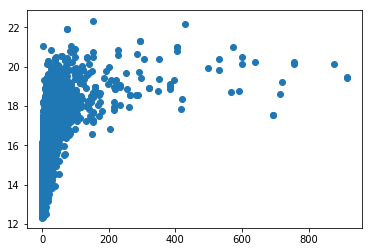

In [204]:
train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["building_area"], train_Y)

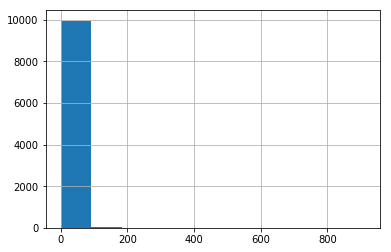

In [205]:
Test_data["building_area"] = Test_data["building_area"].clip(0, Train_data["building_area"].max())

Test_data["building_area"].clip(0, Train_data["building_area"].max()).hist()

In [206]:
Train_data = Train_data.drop(['total_price'] , axis=1)

Train_data = Train_data.drop(['parking_area'] , axis=1)
Test_data = Test_data.drop(['parking_area'] , axis=1)

In [207]:
df = pd.concat([Train_data,Test_data])
df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_price,txn_floor,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,3.0,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,5.0,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,1.0,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,81138.889762,13.0,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [210]:
parking_price = df['parking_price']

df = df.drop(['parking_price'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price

In [211]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

In [212]:
XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

[22:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,58,1,157,1,2483,1,6011,1,34.469803,5.523674
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,28,1,115,1,15872,1,32221,1,40.073573,10.403381
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,78,1,212,1,15760,1,32228,1,54.462081,10.489653
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,20,1,125,1,2568,1,7271,1,99.628966,11.303930
4,1,21,20657,2,4,2,6880,2,5.393602,61.306524,...,18,1,47,1,2587,1,7442,1,124.131236,8.374403


In [260]:
temp_df = copy.deepcopy(df)

In [261]:
temp_df = temp_df.fillna(temp_df.mean())

temp_df["parking_price"] = temp_df["parking_price"].clip(1, temp_df["parking_price"].max())

temp_df["txn_dt"] = temp_df["txn_dt"]/100
temp_df["building_complete_dt"] = temp_df["building_complete_dt"]/100

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])
temp_df["town_area"] = temp_df["town_area"].clip(1, 150)

temp_df["per_building_area"] = temp_df["building_area"] / temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]

temp_df["area_diff"] = temp_df["land_area"] - temp_df["building_area"]
temp_df['area_type'] = temp_df['area_diff'].apply(area_type)

temp_df = temp_df.fillna(temp_df.mean())

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [262]:
temp_df = temp_df.drop(['doc_rate', 'master_rate', 'jobschool_rate', 'highschool_rate'] , axis=1)
temp_df = temp_df.drop(['XIII_5000'] , axis=1)

temp_df = temp_df.drop(['town'] , axis=1)
temp_df = temp_df.drop(['village'] , axis=1)

In [263]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]

temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city", "building_type", "building_use", "total_floor", "txn_floor"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [264]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,per_building_area,total_income,area_percent,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,-39.14,117.08,6.350886,24219.0,...,0.854544,11.943494,12.812980,14.726285,1,14.761401,15.617864,15.495296,15.607997,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,-37.66,119.28,6.311735,551480.0,...,0.808262,15.062772,0.492159,7.345919,1,15.732891,15.368829,15.495296,15.398017,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,-37.67,119.29,6.439350,551480.0,...,1.396070,15.082789,0.926072,15.842523,1,15.732891,15.368829,15.495296,15.607997,15.785761
3,8,203.85,183.25,0,11.387227,13.563031,-39.13,117.09,6.857514,139259.0,...,0.565126,13.769437,0.771895,-2.175803,0,14.761401,15.837270,15.495296,16.127585,15.832799
4,1,206.57,68.80,2,61.306524,4.688108,-39.24,117.19,6.285998,112397.0,...,2.344054,13.468119,0.862986,56.618416,1,14.761401,15.426263,15.495296,14.951800,15.426263


In [265]:
train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [266]:
estimator = xgb.XGBRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=train_X.columns)
feats = feats.sort_values(ascending=False)

[23:23:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [267]:
est = RandomForestRegressor()
est.fit(train_X, train_Y)
feats_est = pd.Series(data=est.feature_importances_, index=train_X.columns)
feats_est = feats_est.sort_values(ascending=False)

In [268]:
high_feature = list(set(feats[feats!=0].index)&set(feats_est[feats_est!=0].index))

In [241]:
head = ["II", "III", "IX", "N"]
remove = []

for f in high_feature:
    if ("0" in f) and (f.split("_")[1] != "10000") and (f.split("_")[0] not in head):
        remove.append(f)
        
for f in remove:
    high_feature.remove(f)

In [269]:
head = ["II", "III", "IX", "N"]
remove = []

for f in high_feature:
    if ("0" in f) and (int(f.split("_")[1]) <= 10000) and(f.split("_")[0] not in head):
        if f != "XIII_10000":
            remove.append(f)
        
for f in remove:
    high_feature.remove(f)

In [270]:
remove

['XIV_1000',
 'I_1000',
 'VIII_1000',
 'IV_10000',
 'VIII_250',
 'VII_250',
 'VI_10000',
 'V_500',
 'VII_500',
 'X_10000',
 'XIV_10000',
 'XIV_5000',
 'V_10000',
 'X_1000',
 'V_1000',
 'V_250',
 'XI_1000',
 'XII_10000',
 'IV_1000',
 'VIII_100',
 'VI_5000',
 'VII_10000',
 'XI_10000',
 'VIII_10000',
 'X_5000',
 'X_500',
 'VII_50',
 'I_10000',
 'V_5000',
 'VIII_500',
 'VII_1000',
 'XI_5000',
 'VII_100',
 'XII_5000']

In [271]:
high_feature

['X_MIN',
 'N_50',
 'I_MIN',
 'III_MIN',
 'total_floor_mean',
 'town_population',
 'IX_MIN',
 'area_diff',
 'II_MIN',
 'town_population_density',
 'building_complete_dt',
 'town_area',
 'total_income',
 'area_percent',
 'IX_1000',
 'XI_MIN',
 'lat',
 'lon',
 'VIII_MIN',
 'land_area',
 'III_50',
 'building_area',
 'per_building_area',
 'IX_500',
 'village_income_median',
 'bachelor_rate',
 'building_type_mean',
 'building_material',
 'II_250',
 'divorce_rate',
 'III_1000',
 'txn_dt',
 'txn_floor_mean',
 'parking_price',
 'XIII_MIN',
 'XIII_10000',
 'parking_way',
 'city_mean',
 'elementary_rate',
 'born_rate']

In [272]:
train_X = train_X[high_feature]
test_X = test_X[high_feature]

In [273]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

0.9401220279671915
Mean squared error: 0.0741


In [274]:
estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-06-28.csv",index=False)

In [41]:
def MAPE(object_, predict_):
    n = len(predict_)
    return sum(abs((predict_-object_)/object_))/n

def HitRate(object_, predict_):
    n = len(predict_)
    Z = [(p - o)/o for o,p in zip(object_, predict_)]
    Z = list(map(lambda x : 1 if x <= 0.1 else 0, Z))
        
    return sum(Z)/n

def Score(object_, predict_):
    if MAPE(object_, predict_)>=1:
        m = 1
    else:
        m = MAPE(object_, predict_)
        
    return (round(HitRate(object_, predict_), 4)*(10**4)) + (1-m)

In [275]:
Score(y_test, y_pred)

9991.98788407826

In [276]:
train_X["total_price"] = train_Y

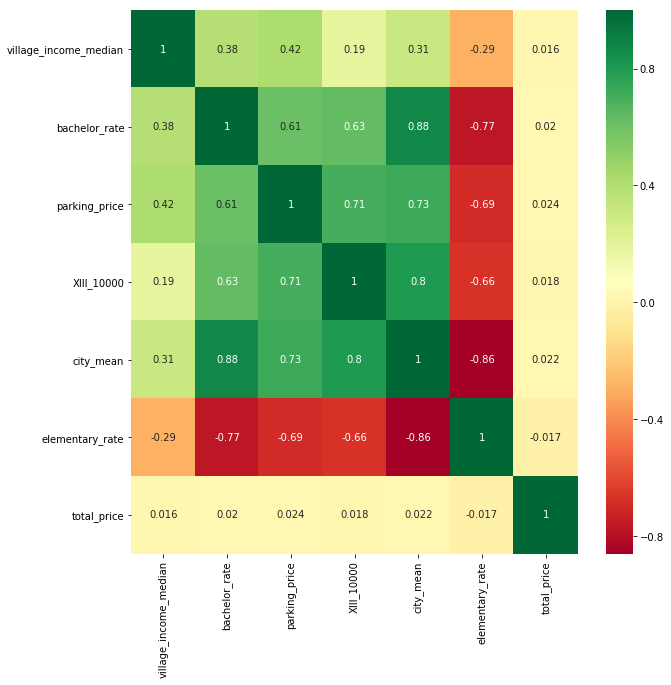

In [277]:
corrmat = train_X.corr()
top_corr_features = corrmat.index[abs(corrmat["total_price"])>0.016]
plt.figure(figsize=(10,10))
g = sns.heatmap(train_X[top_corr_features].corr(),annot=True,cmap="RdYlGn")